# Focality Branch
- find a way of simulating focal vs non-focal tasks

In [1]:
from glob import glob as glob
import torch as tr
import numpy as np

from PMmodel import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# train and eval script

In [2]:
## task
nback=2
num_og_tokens=3
num_pm_trials = 3
seqlen = 25
## network
edim = 5
stsize = 10
batch=1
outdim=3
arch = 'wmem'

In [5]:
# model and task
if arch=='purewm':
  net = Net(edim,stsize,outdim)
elif arch=='wmem':
  net = Net_wmem(edim,stsize,outdim)
task = NBackPMTask(nback,num_og_tokens,num_pm_trials,edim)

# specify loss and optimizer
lossop = tr.nn.CrossEntropyLoss(weight=tr.Tensor([1,1,1]))
optiop = tr.optim.Adam(net.parameters(), lr=0.005)

### train

In [13]:
edim_og = edim_pm = 4
task = NBackPMTask(nback,num_og_tokens,num_pm_trials,edim_og,edim_pm,focal=True)
xseq,yseq = task.gen_seq(seqlen)
xseq == task.pm_token


array([ True, False,  True, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [9]:
thresh = .99
nepochs = 10
L = -np.ones([nepochs])
A = -np.ones([nepochs])
E = -np.ones([nepochs])

acc = 0
nembeds = 0
for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  # randomize emat
  if acc>thresh:
    task.sample_emat()
    nembeds+=1
  # generate data
  x_seq,y_seq = task.gen_seq(seqlen)
  x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
  # forward prop
  yhat = net(x_embeds)
  # collect loss through time
  loss,acc = 0,0
  for yh,yt in zip(yhat,ytarget):
    loss += lossop(yh,yt)
    acc += yt==tr.argmax(tr.softmax(yh,1))
  acc = acc.numpy()/seqlen
  # bp and update
  optiop.zero_grad()
  loss.backward()
  optiop.step()
  epoch_loss = loss.item()
  L[ep] = epoch_loss
  A[ep] = acc
  E[ep] = nembeds

0.0
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
0.2
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
0.4
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
0.6
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
0.8
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([25, 1, 5]) torch.Size([25, 1])


### eval

In [88]:
seqlen = 15
neps = 1500
score = -np.ones([neps,seqlen])

for ep in range(neps):
  # embedding matrix
  Emat = tr.FloatTensor(num_og_tokens+1,edim).uniform_(0,1)
  # generate data
  x_int,ytarget = task.gen_seq(seqlen,pm_trial_position=[5,9])
  ytarget = tr.LongTensor(ytarget).unsqueeze(1)
  # embed inputs
  x_embeds = Emat[x_int]
  x_embeds = x_embeds.unsqueeze(1)
  # forward prop
  yhat = net(x_embeds)
  ep_score = (ytarget == tr.softmax(yhat,-1).argmax(-1)).float().squeeze()
  score[ep] = ep_score 



[autoreload of PMmodel failed: Traceback (most recent call last):
  File "/Users/abeukers/anaconda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/Users/abeukers/wd/pm/PMmodel.py", line 47
    self.emat =
               ^
SyntaxError: invalid syntax
]


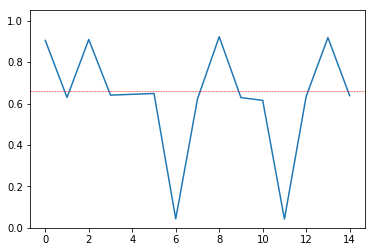

In [89]:
plt.plot(score.mean(0))
plt.ylim(0,1.05)
plt.axhline(.66,c='r',lw=.5,ls='--')

array([[0.66037688, 0.99949   ],
       [0.05628228, 0.15712528]])